### PART 1

100%|██████████| 26421880/26421880 [00:00<00:00, 108763162.88it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6119371.36it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 54398925.69it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10061638.86it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



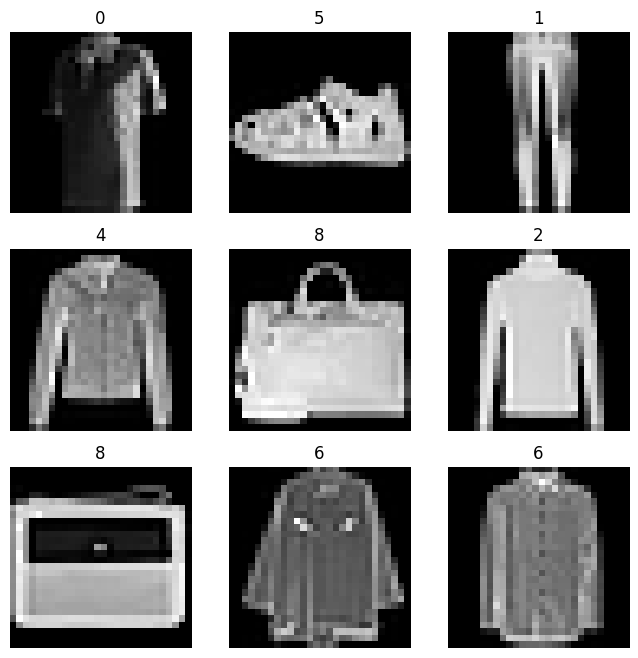

Training Config 1 - Hidden Layers: 3, Hidden Sizes: [32, 64, 128], Epochs: 25, Learning Rate: 0.001, Optimizer: Adam, Batch Size: 64
Epoch 1, Batch 100, Loss: 1.3235519593954086
Epoch 1, Batch 200, Loss: 0.6795186570286751
Epoch 1, Batch 300, Loss: 0.574511616230011
Epoch 1, Batch 400, Loss: 0.5347847455739975
Epoch 1, Batch 500, Loss: 0.4928805217146873
Epoch 1, Batch 600, Loss: 0.48437252908945083
Epoch 1, Batch 700, Loss: 0.482484535574913
Epoch 1, Batch 800, Loss: 0.45929165720939635
Epoch 1, Batch 900, Loss: 0.4447591896355152
Epoch 2, Batch 100, Loss: 0.4424116297066212
Epoch 2, Batch 200, Loss: 0.41293307855725286
Epoch 2, Batch 300, Loss: 0.42920355558395384
Epoch 2, Batch 400, Loss: 0.4170027989149094
Epoch 2, Batch 500, Loss: 0.4047472262382507
Epoch 2, Batch 600, Loss: 0.40790095180273056
Epoch 2, Batch 700, Loss: 0.40989184617996216
Epoch 2, Batch 800, Loss: 0.4163768395781517
Epoch 2, Batch 900, Loss: 0.38870574727654456
Epoch 3, Batch 100, Loss: 0.3899513308703899
Epoch 3

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Labels Mapping
labels_map = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
              5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}

# Displaying sample images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_size):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.hidden_layers.extend([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

def train_model(hidden_layers, hidden_sizes, num_epochs, learning_rate, optimizer_type, batch_size):
    # Data Loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLP(28*28, 10, hidden_layers, hidden_sizes[0])
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.view(inputs.size(0), -1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0

    print('Finished Training')

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.view(images.size(0), -1))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy}%')

    return accuracy

# Define possible hidden layer sizes for each configuration

configurations_with_hidden_sizes = [
    {"hidden_sizes": [32, 64, 128], "learning_rate": 0.001, "optimizer": "Adam", "batch_size": 64},
    {"hidden_sizes": [64, 128, 256], "learning_rate": 0.001, "optimizer": "RMSprop", "batch_size": 128},
    {"hidden_sizes": [32, 64, 128], "learning_rate": 0.001, "optimizer": "Adam", "batch_size": 256},
    {"hidden_sizes": [64, 128], "learning_rate": 0.001, "optimizer": "SGD", "batch_size": 64},
    {"hidden_sizes": [64, 128], "learning_rate": 0.0005, "optimizer": "Adam", "batch_size": 128},
    {"hidden_sizes": [128, 256], "learning_rate": 0.001, "optimizer": "Adam", "batch_size": 64},
    {"hidden_sizes": [32, 64], "learning_rate": 0.0001, "optimizer": "SGD", "batch_size": 256},
    {"hidden_sizes": [64, 128, 256], "learning_rate": 0.0015, "optimizer": "Adam", "batch_size": 128},
    {"hidden_sizes": [32, 64], "learning_rate": 0.0015, "optimizer": "RMSprop", "batch_size": 64},
    {"hidden_sizes": [128, 256], "learning_rate": 0.0005, "optimizer": "Adam", "batch_size": 128},
    {"hidden_sizes": [32, 64, 128], "learning_rate": 0.0015, "optimizer": "Adam", "batch_size": 256},
    {"hidden_sizes": [64, 128], "learning_rate": 0.001, "optimizer": "Adam", "batch_size": 64},
    {"hidden_sizes": [32, 64], "learning_rate": 0.0005, "optimizer": "SGD", "batch_size": 128},
    {"hidden_sizes": [64, 128, 256], "learning_rate": 0.001, "optimizer": "SGD", "batch_size": 256},
    {"hidden_sizes": [32, 64, 128], "learning_rate": 0.001, "optimizer": "SGD", "batch_size": 128},
    {"hidden_sizes": [64, 128], "learning_rate": 0.0015, "optimizer": "RMSprop", "batch_size": 64},
    {"hidden_sizes": [128, 256], "learning_rate": 0.0001, "optimizer": "SGD", "batch_size": 256},
    {"hidden_sizes": [32, 64], "learning_rate": 0.001, "optimizer": "SGD", "batch_size": 128},
    {"hidden_sizes": [64, 128, 256], "learning_rate": 0.001, "optimizer": "SGD", "batch_size": 256},
    {"hidden_sizes": [32, 64, 128], "learning_rate": 0.0001, "optimizer": "Adam", "batch_size": 64}
]


dynamic_configurations = []

best_accuracy = 0.0
best_config = None
# Train and evaluate each configuration
for i, config in enumerate(configurations_with_hidden_sizes, start=1):
    hidden_sizes = config["hidden_sizes"]
    num_hidden_layers = len(hidden_sizes)
    learning_rate = config["learning_rate"]
    optimizer_type = config["optimizer"]
    batch_size = config["batch_size"]

    # Create configuration
    configuration = {
        "name": f"Config {i}",
        "hidden_layers": num_hidden_layers,
        "hidden_size": hidden_sizes,
        "num_epochs": 25,
        "learning_rate": learning_rate,
        "optimizer": optimizer_type,
        "batch_size": batch_size
    }
    dynamic_configurations.append(configuration)

# Train and evaluate each configuration
for config in dynamic_configurations:
    hidden_layers = config["hidden_layers"]
    hidden_sizes = config["hidden_size"]
    num_epochs = config["num_epochs"]
    learning_rate = config["learning_rate"]
    optimizer_type = config["optimizer"]
    batch_size = config["batch_size"]

    print(f"Training {config['name']} - Hidden Layers: {hidden_layers}, Hidden Sizes: {hidden_sizes}, Epochs: {num_epochs}, Learning Rate: {learning_rate}, Optimizer: {optimizer_type}, Batch Size: {batch_size}")
    accuracy = train_model(hidden_layers, hidden_sizes, num_epochs, learning_rate, optimizer_type, batch_size)
    print(f"Accuracy on test set for {config['name']}: {accuracy}\n")

    # Update best accuracy if needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f"Best Configuration - Name: {best_config['name']}, Hidden Layers: {best_config['hidden_layers']}, Hidden Sizes: {best_config['hidden_size']}, Accuracy: {best_accuracy}")


### PART 2


Training Model 1 with Configuration: {'num_layers': 2, 'kernel_depth': 32, 'pool_size': (2, 2), 'dropout_rate': 0.25, 'optimizer': 'SGD', 'learning_rate': 0.01, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 33s 34ms/step - loss: 0.9372 - accuracy: 0.6726 - val_loss: 0.5991 - val_accuracy: 0.7803
Epoch 2/10
938/938 [==============================] - 32s 35ms/step - loss: 0.5736 - accuracy: 0.7919 - val_loss: 0.5692 - val_accuracy: 0.7825
Epoch 3/10
938/938 [==============================] - 32s 34ms/step - loss: 0.5106 - accuracy: 0.8174 - val_loss: 0.4922 - val_accuracy: 0.8179
Epoch 4/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4740 - accuracy: 0.8296 - val_loss: 0.4666 - val_accuracy: 0.8285
Epoch 5/10
938/938 [==============================] - 33s 35ms/step - loss: 0.4473 - accuracy: 0.8388 - val_loss: 0.4467 - val_accuracy: 0.8353
Epoch 6/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4290 - accuracy: 0.8448

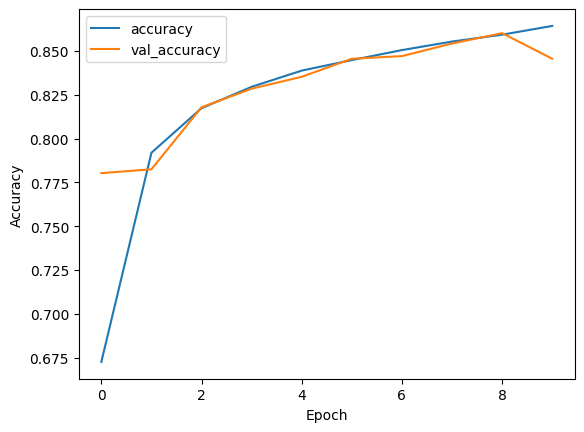

Training Model 2 with Configuration: {'num_layers': 3, 'kernel_depth': 64, 'pool_size': (2, 2), 'dropout_rate': 0.3, 'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 72s 150ms/step - loss: 0.5078 - accuracy: 0.8177 - val_loss: 0.3353 - val_accuracy: 0.8784
Epoch 2/10
469/469 [==============================] - 57s 123ms/step - loss: 0.3047 - accuracy: 0.8912 - val_loss: 0.2868 - val_accuracy: 0.8967
Epoch 3/10
469/469 [==============================] - 54s 114ms/step - loss: 0.2535 - accuracy: 0.9088 - val_loss: 0.2669 - val_accuracy: 0.9025
Epoch 4/10
469/469 [==============================] - 57s 122ms/step - loss: 0.2201 - accuracy: 0.9196 - val_loss: 0.2535 - val_accuracy: 0.9040
Epoch 5/10
469/469 [==============================] - 54s 115ms/step - loss: 0.1957 - accuracy: 0.9284 - val_loss: 0.2619 - val_accuracy: 0.9111
Epoch 6/10
469/469 [==============================] - 58s 123ms/step - loss: 0.1710 - accuracy

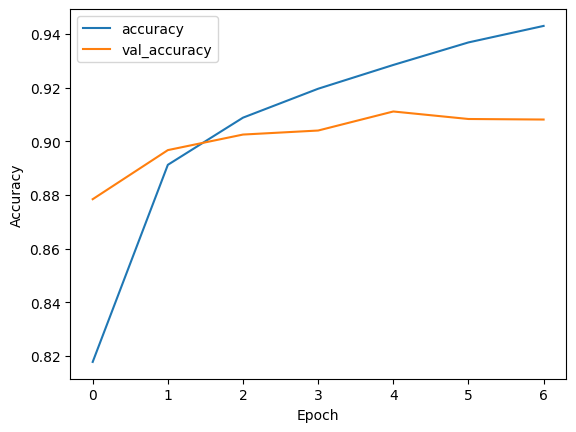

Training Model 3 with Configuration: {'num_layers': 2, 'kernel_depth': 32, 'pool_size': (3, 3), 'dropout_rate': 0.25, 'optimizer': 'RMSprop', 'learning_rate': 0.0001, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 28s 29ms/step - loss: 0.9009 - accuracy: 0.6930 - val_loss: 0.5689 - val_accuracy: 0.7947
Epoch 2/10
938/938 [==============================] - 27s 29ms/step - loss: 0.5350 - accuracy: 0.8062 - val_loss: 0.4777 - val_accuracy: 0.8322
Epoch 3/10
938/938 [==============================] - 27s 29ms/step - loss: 0.4660 - accuracy: 0.8324 - val_loss: 0.4320 - val_accuracy: 0.8466
Epoch 4/10
938/938 [==============================] - 28s 29ms/step - loss: 0.4233 - accuracy: 0.8496 - val_loss: 0.4152 - val_accuracy: 0.8489
Epoch 5/10
938/938 [==============================] - 27s 28ms/step - loss: 0.3969 - accuracy: 0.8590 - val_loss: 0.3942 - val_accuracy: 0.8577
Epoch 6/10
938/938 [==============================] - 27s 29ms/step - loss: 0.3753 - accuracy: 

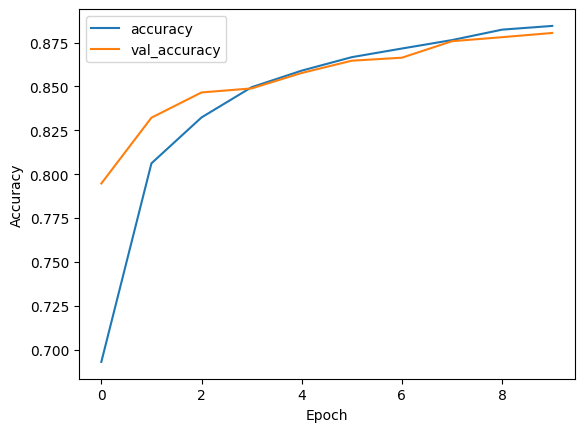

Training Model 4 with Configuration: {'num_layers': 4, 'kernel_depth': 128, 'pool_size': (2, 2), 'dropout_rate': 0.4, 'optimizer': 'SGD', 'learning_rate': 0.005, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 114s 241ms/step - loss: 2.0119 - accuracy: 0.3420 - val_loss: 1.2449 - val_accuracy: 0.6215
Epoch 2/10
469/469 [==============================] - 120s 256ms/step - loss: 1.0784 - accuracy: 0.5872 - val_loss: 0.8292 - val_accuracy: 0.6808
Epoch 3/10
469/469 [==============================] - 120s 256ms/step - loss: 0.8278 - accuracy: 0.6903 - val_loss: 0.6896 - val_accuracy: 0.7492
Epoch 4/10
469/469 [==============================] - 124s 265ms/step - loss: 0.6995 - accuracy: 0.7480 - val_loss: 0.6113 - val_accuracy: 0.7692
Epoch 5/10
469/469 [==============================] - 119s 254ms/step - loss: 0.6273 - accuracy: 0.7768 - val_loss: 0.5608 - val_accuracy: 0.7951
Epoch 6/10
469/469 [==============================] - 122s 260ms/step - loss: 0.5864 - ac

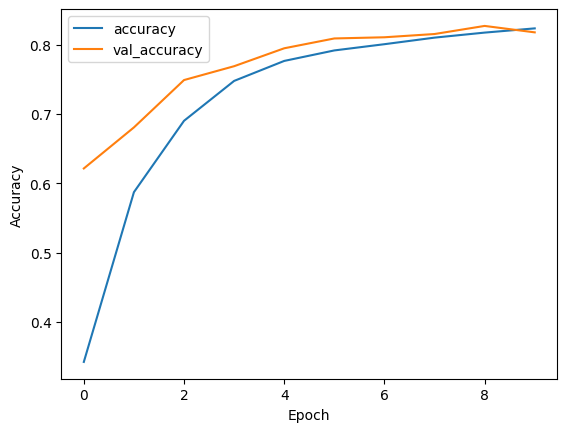

Training Model 5 with Configuration: {'num_layers': 3, 'kernel_depth': 64, 'pool_size': (3, 3), 'dropout_rate': 0.3, 'optimizer': 'Adam', 'learning_rate': 0.0005, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 46s 47ms/step - loss: 0.5724 - accuracy: 0.7941 - val_loss: 0.3783 - val_accuracy: 0.8675
Epoch 2/10
938/938 [==============================] - 43s 46ms/step - loss: 0.3549 - accuracy: 0.8740 - val_loss: 0.3200 - val_accuracy: 0.8876
Epoch 3/10
938/938 [==============================] - 43s 46ms/step - loss: 0.3050 - accuracy: 0.8916 - val_loss: 0.3232 - val_accuracy: 0.8842
Epoch 4/10
938/938 [==============================] - 43s 46ms/step - loss: 0.2738 - accuracy: 0.9002 - val_loss: 0.2985 - val_accuracy: 0.8910
Epoch 5/10
938/938 [==============================] - 42s 45ms/step - loss: 0.2496 - accuracy: 0.9090 - val_loss: 0.2761 - val_accuracy: 0.8992
Epoch 6/10
938/938 [==============================] - 42s 45ms/step - loss: 0.2291 - accuracy: 0.91

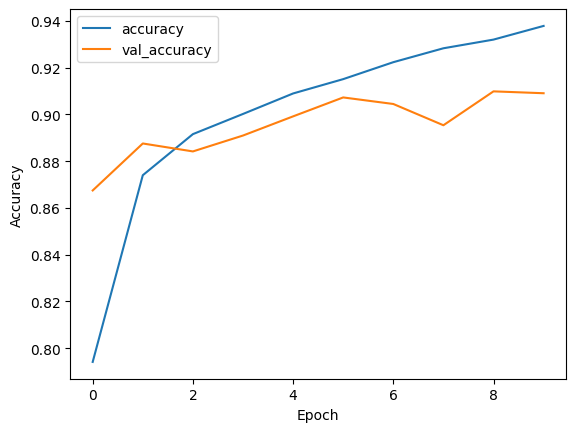

Training Model 6 with Configuration: {'num_layers': 2, 'kernel_depth': 32, 'pool_size': (2, 2), 'dropout_rate': 0.25, 'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 34s 72ms/step - loss: 0.5052 - accuracy: 0.8223 - val_loss: 0.3304 - val_accuracy: 0.8824
Epoch 2/10
469/469 [==============================] - 31s 67ms/step - loss: 0.3104 - accuracy: 0.8882 - val_loss: 0.2870 - val_accuracy: 0.8947
Epoch 3/10
469/469 [==============================] - 31s 67ms/step - loss: 0.2609 - accuracy: 0.9057 - val_loss: 0.2653 - val_accuracy: 0.9027
Epoch 4/10
469/469 [==============================] - 32s 69ms/step - loss: 0.2273 - accuracy: 0.9168 - val_loss: 0.2588 - val_accuracy: 0.9056
Epoch 5/10
469/469 [==============================] - 31s 66ms/step - loss: 0.2066 - accuracy: 0.9235 - val_loss: 0.2523 - val_accuracy: 0.9086
Epoch 6/10
469/469 [==============================] - 32s 69ms/step - loss: 0.1858 - accuracy: 0.9

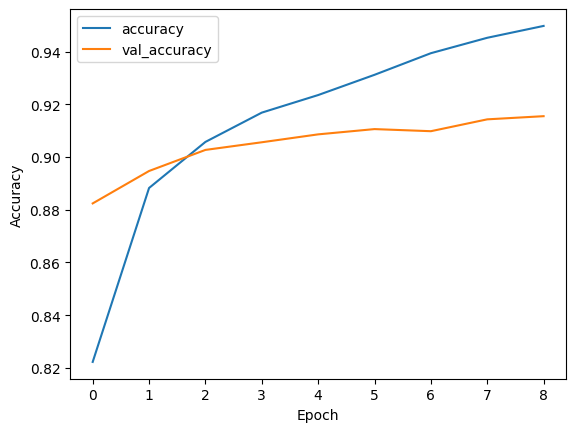

Training Model 7 with Configuration: {'num_layers': 3, 'kernel_depth': 64, 'pool_size': (3, 3), 'dropout_rate': 0.3, 'optimizer': 'SGD', 'learning_rate': 0.01, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 43s 45ms/step - loss: 1.2113 - accuracy: 0.5630 - val_loss: 0.7046 - val_accuracy: 0.7370
Epoch 2/10
938/938 [==============================] - 41s 43ms/step - loss: 0.6588 - accuracy: 0.7543 - val_loss: 0.6069 - val_accuracy: 0.7646
Epoch 3/10
938/938 [==============================] - 42s 45ms/step - loss: 0.5713 - accuracy: 0.7875 - val_loss: 0.5674 - val_accuracy: 0.7826
Epoch 4/10
938/938 [==============================] - 41s 44ms/step - loss: 0.5249 - accuracy: 0.8038 - val_loss: 0.4992 - val_accuracy: 0.8197
Epoch 5/10
938/938 [==============================] - 41s 43ms/step - loss: 0.4956 - accuracy: 0.8180 - val_loss: 0.4674 - val_accuracy: 0.8254
Epoch 6/10
938/938 [==============================] - 41s 44ms/step - loss: 0.4711 - accuracy: 0.8268 

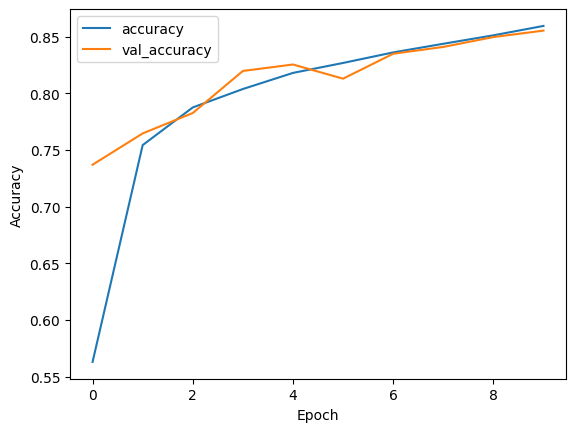

Training Model 8 with Configuration: {'num_layers': 4, 'kernel_depth': 128, 'pool_size': (2, 2), 'dropout_rate': 0.4, 'optimizer': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 126s 266ms/step - loss: 0.5930 - accuracy: 0.7844 - val_loss: 0.3916 - val_accuracy: 0.8581
Epoch 2/10
469/469 [==============================] - 119s 254ms/step - loss: 0.3297 - accuracy: 0.8836 - val_loss: 0.3045 - val_accuracy: 0.8876
Epoch 3/10
469/469 [==============================] - 119s 254ms/step - loss: 0.2705 - accuracy: 0.9032 - val_loss: 0.3462 - val_accuracy: 0.8811
Epoch 4/10
469/469 [==============================] - 116s 246ms/step - loss: 0.2350 - accuracy: 0.9155 - val_loss: 0.2682 - val_accuracy: 0.9051
Epoch 5/10
469/469 [==============================] - 113s 240ms/step - loss: 0.2070 - accuracy: 0.9254 - val_loss: 0.2909 - val_accuracy: 0.9029
Epoch 6/10
469/469 [==============================] - 116s 247ms/step - loss: 0.1838 

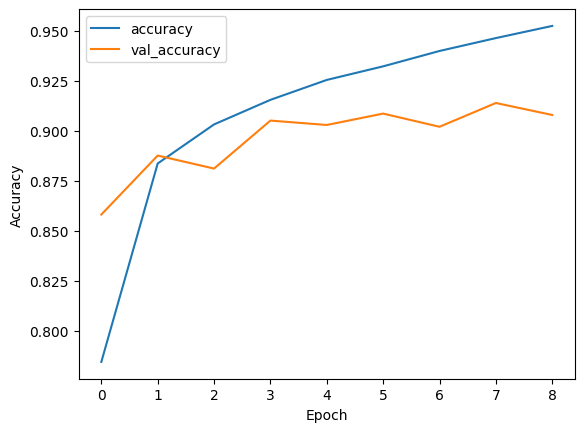

Training Model 9 with Configuration: {'num_layers': 2, 'kernel_depth': 32, 'pool_size': (3, 3), 'dropout_rate': 0.25, 'optimizer': 'Adam', 'learning_rate': 0.05, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 27s 28ms/step - loss: 2.3641 - accuracy: 0.1019 - val_loss: 2.3086 - val_accuracy: 0.1000
Epoch 2/10
938/938 [==============================] - 27s 29ms/step - loss: 2.3075 - accuracy: 0.1009 - val_loss: 2.3051 - val_accuracy: 0.1000
Epoch 3/10
938/938 [==============================] - 26s 27ms/step - loss: 2.3077 - accuracy: 0.0990 - val_loss: 2.3063 - val_accuracy: 0.1000
Epoch 4/10
938/938 [==============================] - 26s 27ms/step - loss: 2.3069 - accuracy: 0.1010 - val_loss: 2.3101 - val_accuracy: 0.1000
Epoch 5/10
938/938 [==============================] - 26s 27ms/step - loss: 2.3071 - accuracy: 0.0989 - val_loss: 2.3060 - val_accuracy: 0.1000
313/313 - 1s - loss: 2.3060 - accuracy: 0.1000 - 1s/epoch - 4ms/step
Test Accuracy for Model 9: 0.10

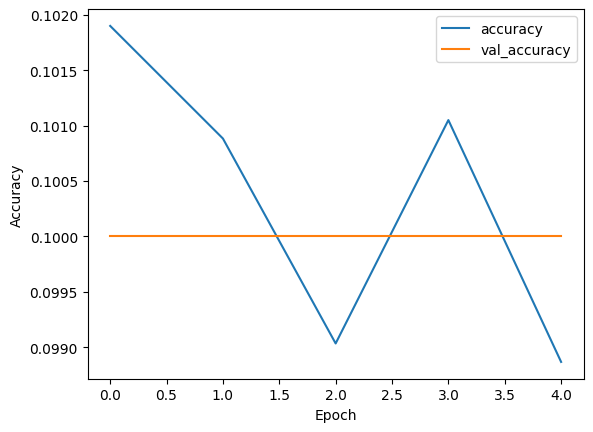

Training Model 10 with Configuration: {'num_layers': 3, 'kernel_depth': 64, 'pool_size': (2, 2), 'dropout_rate': 0.3, 'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 59s 122ms/step - loss: 0.5033 - accuracy: 0.8218 - val_loss: 0.3500 - val_accuracy: 0.8695
Epoch 2/10
469/469 [==============================] - 55s 117ms/step - loss: 0.3001 - accuracy: 0.8920 - val_loss: 0.2877 - val_accuracy: 0.8949
Epoch 3/10
469/469 [==============================] - 55s 118ms/step - loss: 0.2512 - accuracy: 0.9082 - val_loss: 0.2734 - val_accuracy: 0.9003
Epoch 4/10
469/469 [==============================] - 58s 123ms/step - loss: 0.2233 - accuracy: 0.9193 - val_loss: 0.2571 - val_accuracy: 0.9080
Epoch 5/10
469/469 [==============================] - 58s 123ms/step - loss: 0.1933 - accuracy: 0.9293 - val_loss: 0.2478 - val_accuracy: 0.9130
Epoch 6/10
469/469 [==============================] - 55s 118ms/step - loss: 0.1771 - accurac

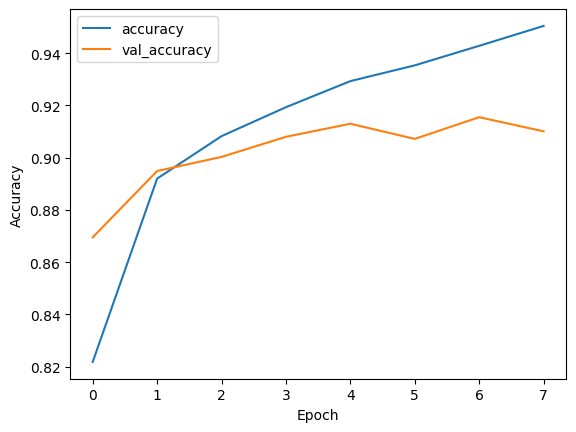

Training Model 11 with Configuration: {'num_layers': 2, 'kernel_depth': 64, 'pool_size': (2, 2), 'dropout_rate': 0.25, 'optimizer': 'SGD', 'learning_rate': 0.0001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 62s 130ms/step - loss: 2.2788 - accuracy: 0.1417 - val_loss: 2.2651 - val_accuracy: 0.1588
Epoch 2/10
469/469 [==============================] - 53s 112ms/step - loss: 2.2534 - accuracy: 0.1849 - val_loss: 2.2410 - val_accuracy: 0.1842
Epoch 3/10
469/469 [==============================] - 54s 116ms/step - loss: 2.2304 - accuracy: 0.2260 - val_loss: 2.2187 - val_accuracy: 0.2314
Epoch 4/10
469/469 [==============================] - 54s 116ms/step - loss: 2.2088 - accuracy: 0.2609 - val_loss: 2.1969 - val_accuracy: 0.3012
Epoch 5/10
469/469 [==============================] - 54s 115ms/step - loss: 2.1868 - accuracy: 0.2937 - val_loss: 2.1746 - val_accuracy: 0.3575
Epoch 6/10
469/469 [==============================] - 54s 115ms/step - loss: 2.1642 - accura

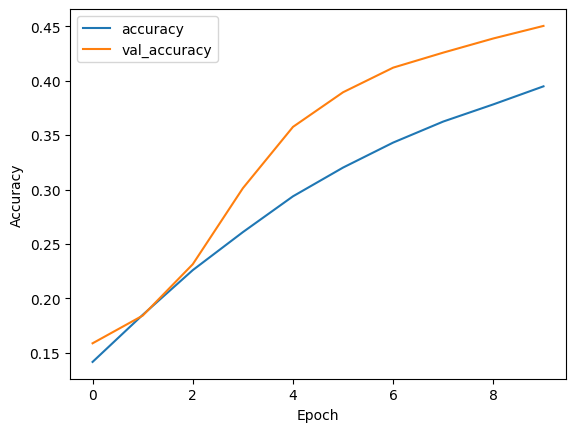

Training Model 12 with Configuration: {'num_layers': 4, 'kernel_depth': 128, 'pool_size': (3, 3), 'dropout_rate': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 78s 82ms/step - loss: 0.5259 - accuracy: 0.8088 - val_loss: 0.3623 - val_accuracy: 0.8696
Epoch 2/10
938/938 [==============================] - 79s 85ms/step - loss: 0.3153 - accuracy: 0.8859 - val_loss: 0.3262 - val_accuracy: 0.8823
Epoch 3/10
938/938 [==============================] - 74s 79ms/step - loss: 0.2728 - accuracy: 0.9006 - val_loss: 0.3030 - val_accuracy: 0.8969
Epoch 4/10
938/938 [==============================] - 73s 78ms/step - loss: 0.2428 - accuracy: 0.9126 - val_loss: 0.2661 - val_accuracy: 0.9025
Epoch 5/10
938/938 [==============================] - 73s 78ms/step - loss: 0.2223 - accuracy: 0.9194 - val_loss: 0.3336 - val_accuracy: 0.8914
Epoch 6/10
938/938 [==============================] - 76s 81ms/step - loss: 0.2048 - accuracy: 

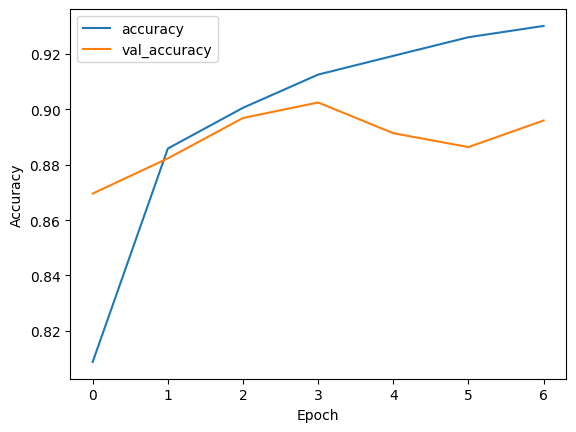

Training Model 13 with Configuration: {'num_layers': 3, 'kernel_depth': 64, 'pool_size': (2, 2), 'dropout_rate': 0.3, 'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 58s 122ms/step - loss: 0.4750 - accuracy: 0.8302 - val_loss: 0.3286 - val_accuracy: 0.8792
Epoch 2/10
469/469 [==============================] - 56s 118ms/step - loss: 0.2841 - accuracy: 0.8991 - val_loss: 0.2837 - val_accuracy: 0.8941
Epoch 3/10
469/469 [==============================] - 57s 122ms/step - loss: 0.2397 - accuracy: 0.9126 - val_loss: 0.2724 - val_accuracy: 0.8992
Epoch 4/10
469/469 [==============================] - 56s 120ms/step - loss: 0.2071 - accuracy: 0.9229 - val_loss: 0.2497 - val_accuracy: 0.9102
Epoch 5/10
469/469 [==============================] - 57s 121ms/step - loss: 0.1814 - accuracy: 0.9330 - val_loss: 0.2573 - val_accuracy: 0.9095
Epoch 6/10
469/469 [==============================] - 54s 116ms/step - loss: 0.1586 - accurac

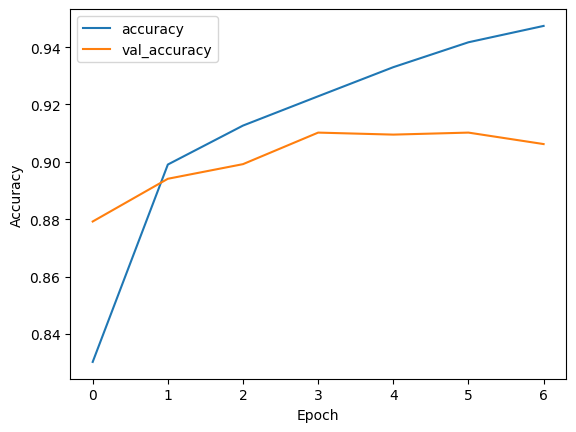

Training Model 14 with Configuration: {'num_layers': 4, 'kernel_depth': 128, 'pool_size': (2, 2), 'dropout_rate': 0.25, 'optimizer': 'Adam', 'learning_rate': 0.0005, 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 119s 251ms/step - loss: 0.5486 - accuracy: 0.8072 - val_loss: 0.3632 - val_accuracy: 0.8661
Epoch 2/10
469/469 [==============================] - 114s 244ms/step - loss: 0.3198 - accuracy: 0.8862 - val_loss: 0.2935 - val_accuracy: 0.8944
Epoch 3/10
469/469 [==============================] - 116s 247ms/step - loss: 0.2709 - accuracy: 0.9037 - val_loss: 0.2749 - val_accuracy: 0.9012
Epoch 4/10
469/469 [==============================] - 115s 244ms/step - loss: 0.2347 - accuracy: 0.9165 - val_loss: 0.2515 - val_accuracy: 0.9081
Epoch 5/10
469/469 [==============================] - 113s 240ms/step - loss: 0.2108 - accuracy: 0.9232 - val_loss: 0.2590 - val_accuracy: 0.9071
Epoch 6/10
469/469 [==============================] - 115s 245ms/step - loss: 0.1903 

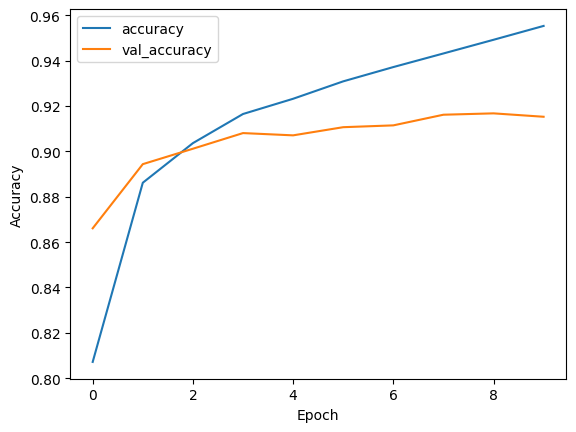

Training Model 15 with Configuration: {'num_layers': 2, 'kernel_depth': 64, 'pool_size': (3, 3), 'dropout_rate': 0.4, 'optimizer': 'SGD', 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
938/938 [==============================] - 45s 47ms/step - loss: 2.2122 - accuracy: 0.1731 - val_loss: 2.0987 - val_accuracy: 0.3710
Epoch 2/10
938/938 [==============================] - 43s 46ms/step - loss: 1.9163 - accuracy: 0.3888 - val_loss: 1.6411 - val_accuracy: 0.5312
Epoch 3/10
938/938 [==============================] - 43s 46ms/step - loss: 1.4627 - accuracy: 0.5120 - val_loss: 1.1888 - val_accuracy: 0.6274
Epoch 4/10
938/938 [==============================] - 43s 45ms/step - loss: 1.1864 - accuracy: 0.5688 - val_loss: 1.0006 - val_accuracy: 0.6473
Epoch 5/10
938/938 [==============================] - 44s 47ms/step - loss: 1.0478 - accuracy: 0.6148 - val_loss: 0.9055 - val_accuracy: 0.6802
Epoch 6/10
938/938 [==============================] - 43s 46ms/step - loss: 0.9643 - accuracy: 0.647

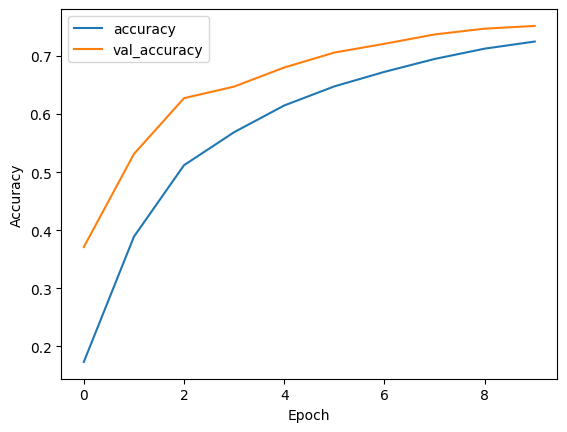

Best Accuracy: 0.9154999852180481


In [9]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define function to create CNN model
def create_cnn_model(num_layers=2, kernel_depth=32, pool_size=(2, 2), dropout_rate=0.25, optimizer='SGD', learning_rate=0.01):
    model = Sequential()
    model.add(Conv2D(kernel_depth, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    if optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define configurations
configurations = [
    {"num_layers": 2, "kernel_depth": 32, "pool_size": (2, 2), "dropout_rate": 0.25, "optimizer": 'SGD', "learning_rate": 0.01, "batch_size": 64},
    {"num_layers": 3, "kernel_depth": 64, "pool_size": (2, 2), "dropout_rate": 0.3, "optimizer": 'Adam', "learning_rate": 0.001, "batch_size": 128},
    {"num_layers": 2, "kernel_depth": 32, "pool_size": (3, 3), "dropout_rate": 0.25, "optimizer": 'RMSprop', "learning_rate": 0.0001, "batch_size": 64},
    {"num_layers": 4, "kernel_depth": 128, "pool_size": (2, 2), "dropout_rate": 0.4, "optimizer": 'SGD', "learning_rate": 0.005, "batch_size": 128},
    {"num_layers": 3, "kernel_depth": 64, "pool_size": (3, 3), "dropout_rate": 0.3, "optimizer": 'Adam', "learning_rate": 0.0005, "batch_size": 64},
    {"num_layers": 2, "kernel_depth": 32, "pool_size": (2, 2), "dropout_rate": 0.25, "optimizer": 'Adam', "learning_rate": 0.001, "batch_size": 128},
    {"num_layers": 3, "kernel_depth": 64, "pool_size": (3, 3), "dropout_rate": 0.3, "optimizer": 'SGD', "learning_rate": 0.01, "batch_size": 64},
    {"num_layers": 4, "kernel_depth": 128, "pool_size": (2, 2), "dropout_rate": 0.4, "optimizer": 'RMSprop', "learning_rate": 0.001, "batch_size": 128},
    {"num_layers": 2, "kernel_depth": 32, "pool_size": (3, 3), "dropout_rate": 0.25, "optimizer": 'Adam', "learning_rate": 0.05, "batch_size": 64},
    {"num_layers": 3, "kernel_depth": 64, "pool_size": (2, 2), "dropout_rate": 0.3, "optimizer": 'Adam', "learning_rate": 0.001, "batch_size": 128},
    {"num_layers": 2, "kernel_depth": 64, "pool_size": (2, 2), "dropout_rate": 0.25, "optimizer": 'SGD', "learning_rate": 0.0001, "batch_size": 128},
    {"num_layers": 4, "kernel_depth": 128, "pool_size": (3, 3), "dropout_rate": 0.3, "optimizer": 'RMSprop', "learning_rate": 0.001, "batch_size": 64},
    {"num_layers": 3, "kernel_depth": 64, "pool_size": (2, 2), "dropout_rate": 0.3, "optimizer": 'Adam', "learning_rate": 0.001, "batch_size": 128},
    {"num_layers": 4, "kernel_depth": 128, "pool_size": (2, 2), "dropout_rate": 0.25, "optimizer": 'Adam', "learning_rate": 0.0005, "batch_size": 128},
    {"num_layers": 2, "kernel_depth": 64, "pool_size": (3, 3), "dropout_rate": 0.4, "optimizer": 'SGD', "learning_rate": 0.001, "batch_size": 64}

]

# Track best accuracy
best_accuracy = 0.0
best_model = None

# Train and evaluate models for each configuration
for i, config in enumerate(configurations, start=1):
    num_layers = config["num_layers"]
    kernel_depth = config["kernel_depth"]
    pool_size = config["pool_size"]
    dropout_rate = config["dropout_rate"]
    optimizer = config["optimizer"]
    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]

    print(f"Training Model {i} with Configuration: {config}")

    # Create and compile model
    model = create_cnn_model(num_layers=num_layers, kernel_depth=kernel_depth, pool_size=pool_size,
                             dropout_rate=dropout_rate, optimizer=optimizer, learning_rate=learning_rate)

    # Train the model
    history = model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=10, batch_size=batch_size, verbose=1,
                        validation_data=(x_test.reshape(-1, 28, 28, 1), y_test), callbacks=[EarlyStopping(patience=3)])

    # Evaluate the model
    loss, accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test, verbose=2)
    print(f"Test Accuracy for Model {i}: {accuracy}")

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Update best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"Best Accuracy: {best_accuracy}")
